In [82]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
from bayesian_pdes.problems import allen_cahn
import sympy as sp
import scipy.stats
#%load_ext line_profiler
import time
import Cython
%load_ext Cython
import mcmc
%load_ext mcmc
%mcmc notebook

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [447]:
n_pts = 3
seed = 123
np.random.seed(seed)
noise_variance = 1e-2

In [448]:

# for now collocate on a basic grid (this is not efficient)
x, y = np.mgrid[0:1:n_pts*1j, 0:1:n_pts*1j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_interior = np.c_[x[~on_bdy], y[~on_bdy]]

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

In [449]:
def cube_root(arr):
    arr = np.asarray(arr)
    ret = np.empty_like(arr)
    ret[arr >= 0] = arr[arr > 0]**(1./3)
    ret[arr < 0] = - np.abs(arr[arr < 0])**(1./3)
    return ret

# Calculation of Importance Distn

In [450]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [451]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [452]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [453]:
def retry(fun, tries, success_condition=None, debug=True):
    for i in xrange(tries):
        try:
            res = fun()
        except Exception as ex:
            if debug: 
                print('Attempt {} failed with exception {}'.format(i, ex))
            continue
        
        if success_condition is not None and success_condition(res):
            return res
        else:
            return res
        if debug:
            print('Attempt {} failed'.format(i))
    raise Exception('Failed to find solution in {} tries'.format(tries))
    
meshes = {}
fn_spaces = {}
bc_store = {}
def find_solutions(delta, mesh_points, initial_guesses=None, max_solutions=3, stop_on_divergence=False):
    # reuse mesh if we can
    if mesh_points in meshes:
        mesh = meshes[mesh_points]
        V = fn_spaces[mesh_points]
        bcs = bc_store[mesh_points]
    else:
        mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
        size = dolfin.MPI.size(dolfin.mpi_comm_world())
        if size > 1:
            nrefine = math.log(size, 4)
            if int(nrefine) != nrefine:
                print("Need to have processors a power of 4, as each refinement multiplies work by 4")
                assert False

            for i in range(int(nrefine) + 3):
                mesh = dolfin.refine(mesh, redistribute=False)
        meshes[mesh_points] = mesh

        V = dolfin.FunctionSpace(mesh, "CG", 1)
        fn_spaces[mesh_points] = V
        

        bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
               dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]
        bc_store[mesh_points] = bcs
    Vdim = V.dim()
    #if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
    #    print "Degrees of freedom: ", Vdim
    #    print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(delta)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in xrange(max_solutions):
        if initial_guesses is not None and len(initial_guesses) > i:
            u.assign(initial_guesses[i])
        dolfin.PETScOptions.set("snes_atol", natol)
        try:
            solver.solve(problem, u.vector())
        except Exception as ex:
            if stop_on_divergence:
                break
            else:
                raise
            
        roots.append(dolfin.Function(u, name="Solution"))

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots

In [454]:
def compute_latent(points, delta, solutions):
    # it is most convenient to compute the latent variables as the cube of the values at the points (i.e. at A_2),
    # since this means we don't have to fuss about with gradients.
    res = np.empty((points.shape[0], len(solutions)))
    for i in xrange(len(solutions)):
        res[:,i] = np.vectorize(solutions[i])(points[:,0], points[:,1])
    return -res**3 / delta

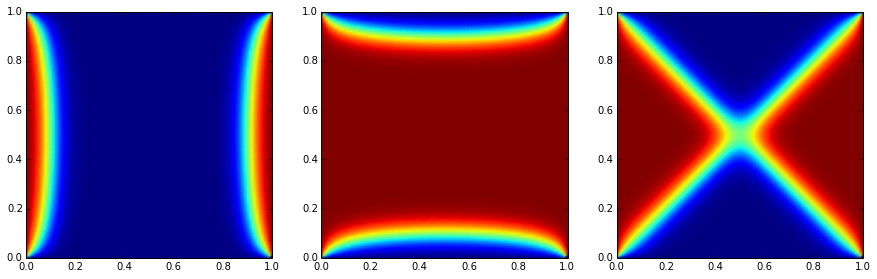

In [455]:
delta = 0.04
true_solutions = find_solutions(delta, 100, max_solutions=3, stop_on_divergence=False)
plt.figure(figsize=(15,5))
for ix, solution in enumerate(true_solutions):
    plt.subplot(1,3,ix)
    plot(solution)
    plt.gcf().patch.set_alpha(0.0)

In [456]:
data_x, data_y = np.mgrid[0:1:6j, 0:1:6j]
flags = (data_x > 0) & (data_x < 1) & (data_y > 0) & (data_y < 1)
data_x = data_x[flags].reshape((4,4))
data_y = data_y[flags].reshape(4,4)
data_pts = np.c_[data_x.ravel(), data_y.ravel()]
true_solution_values = np.vectorize(true_solutions[0])(data_pts[:,0], data_pts[:,1])

true_solution_values = true_solution_values + np.random.normal(0, noise_variance)
true_obs = (data_pts, true_solution_values)

A sensible range looks like $\delta \in [0.035, 0.1]$. It looks (however) as though while it becomes difficult to find solutions after this point, the three-solution regime is not broken until closer to $\delta=0.2$

# Calculation of PN Probability

In [459]:
ls = 0.5

In [460]:
from scipy.spatial import distance
z_length_scale = ls
kern_mat = np.exp(-distance.cdist(collocate_interior, collocate_interior) / (2*z_length_scale**2))
#z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), kern_mat)

In [461]:
allen_cahn_system_factory = allen_cahn.AllenCahnFactory()

In [462]:
test_x, test_y = np.mgrid[0:1:20j, 0:1:20j]
test = np.column_stack([test_x.ravel(), test_y.ravel()])

In [463]:
rho = 1e-3
n_samples = 10000
mixture_ix = 0
op_cache = allen_cahn_system_factory.get_operator_system(delta)
ops = op_cache.operators
ops_bar = op_cache.operators_bar

z = compute_latent(collocate_interior, delta, true_solutions)
#dist = scipy.stats.multivariate_normal(np.zeros_like(z[:, mixture_ix], rho)
#dist = scipy.stats.norm(0, rho)


#z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho)
z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho**2*kern_mat)
#z_dist = scipy.stats.norm(0, rho)
estimates = np.empty(n_samples)

obs = [
    (collocate_interior, None),
    (collocate_interior, None),
    (collocate_boundary, None)
]

posterior = bayesian_pdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=np.array([ls]))
true_locations, true_values = true_obs
dot_with_rhs, cov = posterior.no_obs_posterior(true_locations)
mean = np.zeros((n_samples, true_locations.shape[0]))

all_rvs = z_dist.rvs(n_samples)
for i in xrange(n_samples):
    # equal weighting for solutions
    rv = all_rvs[i]
    z_star = z[:, mixture_ix] + rv
    rhs = np.concatenate([z_star, cube_root(-delta*z_star), boundary_obs])
    mu = dot_with_rhs.dot(rhs)
    mean[i,:] = mu

<matplotlib.colorbar.Colorbar instance at 0x7fd9f34112d8>

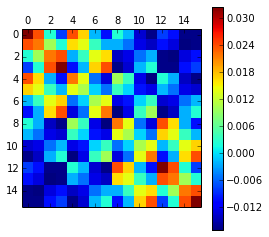

In [464]:
plt.matshow(cov)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fd9f2bcdb48>

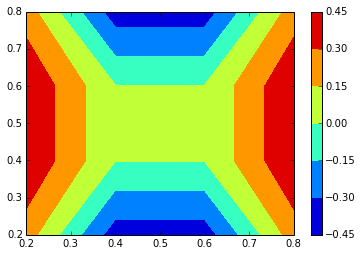

In [465]:
plt.contourf(data_x, data_y, mean.mean(axis=0).reshape(data_x.shape))
plt.colorbar()

In [466]:
mean.mean(axis=0) - true_values

array([ 0.23580034, -0.5340649 , -0.53434258,  0.23577291,  0.61685927,
        0.01501959,  0.0150109 ,  0.61713598,  0.61713598,  0.0150109 ,
        0.01501959,  0.61685927,  0.23577291, -0.53434258, -0.5340649 ,
        0.23580034])

In [467]:
def log_p_pn_estimate(true_obs, delta, solutions, length_scale, sigma, rho, n_samples, debug=False, mixture=None):
    # generate all of the operators and the cache here so we don't have to compute inside the loop (which is slow)
    op_cache = allen_cahn_system_factory.get_operator_system(delta)
    ops = op_cache.operators
    ops_bar = op_cache.operators_bar
    
    z = compute_latent(collocate_interior, delta, solutions)
    #dist = scipy.stats.multivariate_normal(np.zeros_like(z[:, mixture_ix], rho)
    #dist = scipy.stats.norm(0, rho)
    
    
    #z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho)
    z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho**2*kern_mat)
    #z_dist = scipy.stats.norm(0, rho)
    estimates = np.empty(n_samples)
     
    obs = [
        (collocate_interior, None),
        (collocate_interior, None),
        (collocate_boundary, None)
    ]
    
    posterior = bayesian_pdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=np.array([length_scale]))
    true_locations, true_values = true_obs
    dot_with_rhs, cov = posterior.no_obs_posterior(true_locations)
    
    error_mat = np.eye(cov.shape[0])*sigma**2
    Sigma_plus_error = cov + error_mat
    if debug: print(np.trace(cov), np.trace(Sigma_plus_error))
    like_dist = scipy.stats.multivariate_normal(np.zeros(true_locations.shape[0]), Sigma_plus_error)
    
    all_rvs = z_dist.rvs(n_samples)
    for i in xrange(n_samples):
        # equal weighting for solutions
        rv = all_rvs[i]
        z_star = z[:, mixture] + rv
        rhs = np.concatenate([z_star, cube_root(-delta*z_star), boundary_obs])
        mu = dot_with_rhs.dot(rhs)
        discrepancy = mu-true_values

        log_pn_proba = like_dist.logpdf(discrepancy)
        
        # uniformative prior for z so we can ignore
        estimates[i] = log_pn_proba
        if debug:
            print('i={}: Log-PN Proba: {} Discrepancy: {}' \
                .format(i,log_pn_proba, discrepancy.mean()))
    #if debug:
    #    print estimates
    return estimates

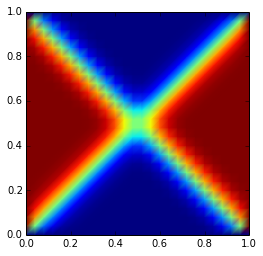

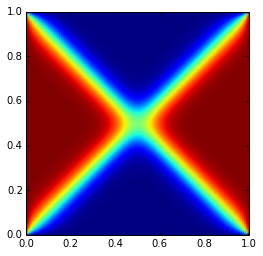

-791.950186988 313.511785345


In [468]:

cur_solutions = find_solutions(0.04, 25)
plot(cur_solutions[2])
plt.show(); plt.close();
plot(true_solutions[0])
plt.show(); plt.close();
e = log_p_pn_estimate(true_obs, 0.04, cur_solutions, ls, noise_variance, 1e-4, 1000, debug=False, mixture=2)
print(np.mean(e), np.std(e))

In [469]:
class LikelihoodClass(object):
    def __init__(self, solutions, solutions_delta):
        self.__solutions__ = solutions
        self.__solutions_delta__ = solutions_delta
    
    def likelihood(self, solution_ix, delta):
        if delta != self.__solutions_delta__:
            solutions = find_solutions(delta, z_mesh_size, initial_guesses=self.__solutions__)
            self.__solutions__ = solutions
        else:
            solutions = self.__solutions__
        ret = log_p_pn_estimate(true_obs, delta, solutions, ls, noise_variance, z_proposal_variance, z_samples, mixture=solution_ix)
        if z_samples == 1:
            return ret
        return np.mean(ret)
        #return np.mean(ret)
    
    def __call__(self, sample):
        solution_ix = int(sample[0])
        delta = sample[1]
        return self.likelihood(solution_ix, delta)

In [470]:
## import sys
# lastly put all of this together to sample from the delta distribution
n_iter = 10000

delta_min = 0.02
delta_max = 0.15
def delta_prior(delta):
    
    if delta[1] < delta_max and delta[1] > delta_min:
        return 1./(delta_max-delta_min)
    return 0
def delta_log_prior(delta):
    if delta[1] < delta_max and delta[1] > delta_min:
        return 0.
    return -np.inf

#prev_delta = (delta_max + delta_min) / 2.
prev_delta = 0.04
delta_proposal_variance = 1e-2
z_proposal_variance = 1e-3
z_samples = 1000
z_mesh_size = 25

#solutions_lambda = lambda delta: retry(lambda: find_solutions(delta, 50), 5, lambda s: len(s) == 3, True)
#print '  Generating solutions'
cur_solutions = find_solutions(prev_delta, z_mesh_size)

likelihood = LikelihoodClass(cur_solutions, prev_delta)
class ProposalClass(object):
    def __init__(self):
        self.proposal_ix = 0
        
    def propose_delta(self, delta):
        return np.random.normal(delta, delta_proposal_variance)
    
    def propose_solution(self):
        return np.random.choice(3)
    
    def __call__(self, current):
        if self.proposal_ix == 0:
            solution = current[0]
            delta = self.propose_delta(current[1])
        else:
            solution = self.propose_solution()
            delta = current[1]
        self.proposal_ix = 1 if self.proposal_ix == 0 else 0
        return np.array([solution, delta])
propose = ProposalClass()

In [471]:
deltas = np.linspace(delta_min, delta_max, 20)
likelihoods = np.empty_like(deltas)
for i, delta in enumerate(deltas):
    likelihoods[i] = likelihood(np.array([2, delta]))

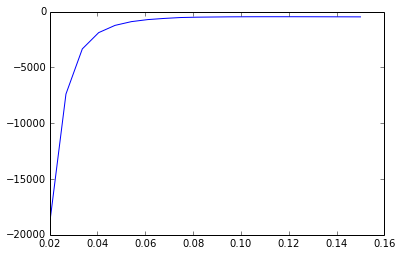

In [472]:
plt.plot(deltas, likelihoods)

In [ ]:
samples = mcmc.rwm(n_iter, propose, likelihood, delta_log_prior, np.array([0, 0.04]))

In [168]:
np.save('delta_n={}.npy'.format(n_pts), samples)

In [169]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot

0.0392358749597


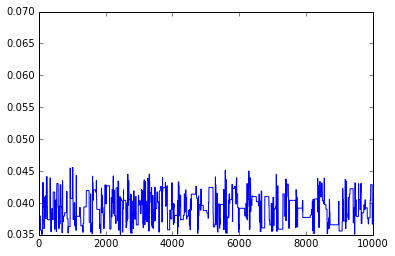

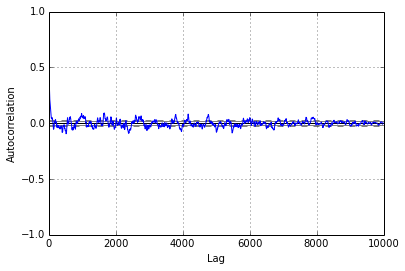

In [170]:
burn = 0
thin = 1
thinned_burned = samples[burn::thin,1]
plt.plot(thinned_burned)
print(np.mean(thinned_burned))
plt.figure()

autocorrelation_plot(thinned_burned)

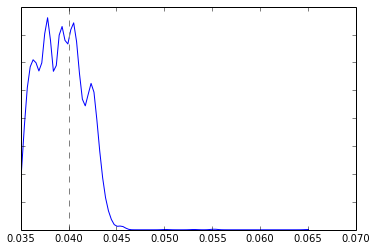

In [171]:
import scipy.stats
delta_samples = samples[:,1]
kde = scipy.stats.gaussian_kde(delta_samples.T)
range = np.linspace(delta_samples.min(), delta_samples.max(), 100)
plt.plot(range, kde(range))
plt.axvline(0.04, color='gray', linestyle='--')
plt.gca().set_yticklabels([])
f = plt.gcf()
f.patch.set_alpha(0.0)
plt.savefig('ac_delta.pdf',  bbox_inches='tight')
#plt.hist(samples, 50);

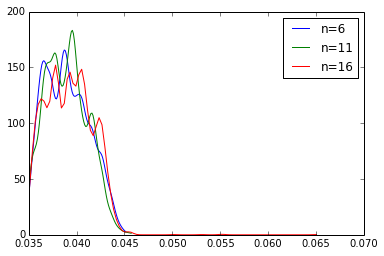

In [174]:
for n in [6, 11, 16]:
    samples = np.load('delta_n={}.npy'.format(n))
    delta = samples[:,1]
    kde = scipy.stats.gaussian_kde(delta.T)
    range = np.linspace(delta.min(), delta.max(), 100)
    plt.plot(range, kde(range), label='n={}'.format(n))
plt.legend()